In [ ]:
!pip install -q transformers datasets accelerate

# 1. Load Hugging Face dataset
from datasets import load_dataset
dataset = load_dataset("clapAI/MultiLingualSentiment")
train_data = dataset["train"]

# 2. Filter to English and Spanish only (label must be 'positive' or 'negative')
def filter_binary(example):
    return example["language"] in ["en", "es"] and example["label"] != "neutral"

filtered = train_data.filter(filter_binary)

# 3. Convert labels to binary: 'positive' = 1, 'negative' = 0
def to_binary(example):
    return {"label": int(example["label"] == "positive")}

binary = filtered.map(to_binary)

# 4. Check counts
from collections import Counter
print("Label counts:", Counter(binary["label"]))
print("Language counts:", Counter(binary["language"]))


In [7]:
from datasets import load_dataset

# 1. Load the multilingual dataset
dataset = load_dataset("clapAI/MultiLingualSentiment")
train_data = dataset["train"]

# 2. Filter to English and Spanish, and exclude neutral
def filter_binary(example):
    return example["language"] in ["en", "es"] and example["label"] != "neutral"

filtered = train_data.filter(filter_binary)

# 3. Convert string labels to binary (positive → 1, negative → 0)
def to_binary(example):
    return {"label": int(example["label"] == "positive")}

binary = filtered.map(to_binary)

# Check
from collections import Counter
print("Label counts:", Counter(binary["label"]))
print("Language counts:", Counter(binary["language"]))



README.md: 0.00B [00:00, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/249M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/314M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/99.1M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/98.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3147478 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/393435 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/393436 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3147478 [00:00<?, ? examples/s]

Map:   0%|          | 0/997278 [00:00<?, ? examples/s]

Label counts: Counter({0: 514067, 1: 483211})
Language counts: Counter({'en': 855463, 'es': 141815})


In [8]:
from transformers import XLMRobertaTokenizer

# Load tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

# Tokenize function
def tokenize_batch(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length")

# Apply to dataset
tokenized = binary.map(tokenize_batch, batched=True)
tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Optional subsample if needed (for quick training)
tokenized = tokenized.shuffle(seed=42).select(range(6000))


Map:   0%|          | 0/997278 [00:00<?, ? examples/s]

In [12]:
# Split 80/20
split = int(0.8 * len(tokenized))
train_dataset = tokenized.select(range(split))
eval_dataset = tokenized.select(range(split, len(tokenized)))

print("Train size:", len(train_dataset), "| Eval size:", len(eval_dataset))


Train size: 4800 | Eval size: 1200


In [13]:
from transformers import XLMRobertaForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=2)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Final split after tokenization
n = len(tokenized)
split = int(n * 0.8)

train_dataset = tokenized.select(range(split))         # 80%
eval_dataset = tokenized.select(range(split, n))       # 20%

print("Train:", len(train_dataset), "| Eval:", len(eval_dataset))


Train: 4800 | Eval: 1200


In [16]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./logs",
    load_best_model_at_end=True,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)


In [17]:
trainer.train()


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.428569,0.844167,0.812401,0.881034,0.845327
2,0.421600,0.368075,0.868333,0.878136,0.844828,0.861160


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=600, training_loss=0.39795509974161786, metrics={'train_runtime': 717.6298, 'train_samples_per_second': 13.377, 'train_steps_per_second': 0.836, 'total_flos': 2525866131456000.0, 'train_loss': 0.39795509974161786, 'epoch': 2.0})

In [18]:
results = trainer.evaluate(eval_dataset)
print(results)


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.36807525157928467, 'eval_accuracy': 0.8683333333333333, 'eval_precision': 0.8781362007168458, 'eval_recall': 0.8448275862068966, 'eval_f1': 0.8611599297012302, 'eval_runtime': 26.3012, 'eval_samples_per_second': 45.625, 'eval_steps_per_second': 2.852, 'epoch': 2.0}


In [19]:
# Pick some sample examples
sample_texts = binary.shuffle(seed=123).select(range(5))
sample_tok = sample_texts.map(tokenize_batch)
sample_tok.set_format("torch", columns=["input_ids", "attention_mask"])

# Predict
predictions = trainer.predict(sample_tok)
pred_labels = predictions.predictions.argmax(axis=1)

# Display
for i, pred in enumerate(pred_labels):
    print(f"📝 Review: {sample_texts[i]['text'][:100]}...")
    print(f"Predicted: {'Positive' if pred else 'Negative'} | True: {'Positive' if sample_texts[i]['label'] else 'Negative'}\n")


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

📝 Review: I LOVE BELLE ANDRE!!!! Let me start by saying that I truly truly enjoy reading Belle Andre books. Ye...
Predicted: Negative | True: Negative

📝 Review: Sylvanian
Como todo lo de Sylvanian es muy cuco. Pongo 4 estrellas porque hay varias cosas de cartón...
Predicted: Negative | True: Positive

📝 Review: Cliente
Mala calidad. Las usé para trabajar y a los pocos días ya tenían roturas en los talones. No ...
Predicted: Negative | True: Negative

📝 Review: They weren't busy so the server was on the money! I tried the pulled pork fajitas and my girlfriend ...
Predicted: Negative | True: Negative

📝 Review: I really liked the poppy seed and all dressed-up bagels. They are fresh out of the oven with a crunc...
Predicted: Positive | True: Positive



/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


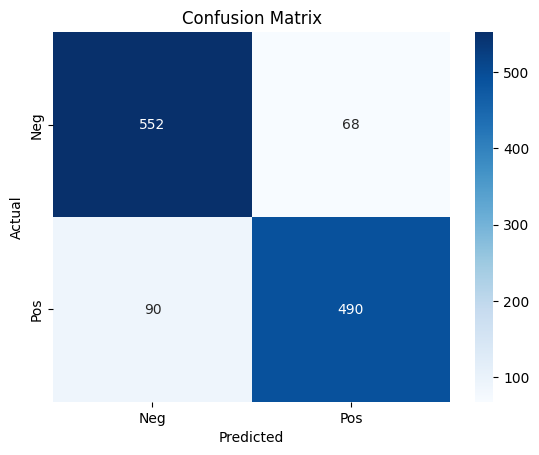

              precision    recall  f1-score   support

    Negative       0.86      0.89      0.87       620
    Positive       0.88      0.84      0.86       580

    accuracy                           0.87      1200
   macro avg       0.87      0.87      0.87      1200
weighted avg       0.87      0.87      0.87      1200



In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Run full predictions on eval set
eval_preds = trainer.predict(eval_dataset)
y_true = eval_preds.label_ids
y_pred = np.argmax(eval_preds.predictions, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Neg", "Pos"], yticklabels=["Neg", "Pos"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))


In [21]:
model.save_pretrained("xlm-roberta-multilingual-sentiment")
tokenizer.save_pretrained("xlm-roberta-multilingual-sentiment")


('xlm-roberta-multilingual-sentiment/tokenizer_config.json',
 'xlm-roberta-multilingual-sentiment/special_tokens_map.json',
 'xlm-roberta-multilingual-sentiment/sentencepiece.bpe.model',
 'xlm-roberta-multilingual-sentiment/added_tokens.json')